# Init

In [83]:
import os
import math

import numpy as np
import fasttext.util

import matplotlib.pyplot as plt

import nn
import utils


import string
import re
from pickle import dump
from unicodedata import normalize


np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='raise', invalid='raise')

%matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

MODEL_DIM = 64
INNER_DIM = MODEL_DIM * 4

SEQ_LEN = 128 # Max length of input or output sentence
NUM_HEADS = 8


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
embeddings = utils.get_embeddings(["en", "fr"], dim=MODEL_DIM) # using MODEL_DIM instead of 512

en_emb = embeddings["en"]
fr_emb = embeddings["fr"]

print(en_emb.get_dimension())
print(fr_emb.get_dimension())

64
64


In [90]:
 
# load doc into memory
def load_doc(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text
 
# split a loaded document into sentences
def to_sentences(doc):
    return doc.strip().split('\n')

# clean a list of lines
def clean_lines(lines):
    cleaned = list()
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        line = line.split()
        line = [word.lower() for word in line]
        line = [word.translate(table) for word in line]
        line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    return cleaned
 
# save a list of clean sentences to file
def save_clean_sentences(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
 
# load English data
filename = 'data/europarl-v7.fr-en.en'
doc = load_doc(filename)
sentences = to_sentences(doc)
english_sentences = clean_lines(sentences[:10000])
save_clean_sentences(english_sentences, 'data/english.pkl')
# spot check
for i in range(10):
    print(sentences[i])
 
# load French data
filename = 'data/europarl-v7.fr-en.fr'
doc = load_doc(filename)
sentences = to_sentences(doc)
french_sentences = clean_lines(sentences[:10000])
save_clean_sentences(french_sentences, 'data/french.pkl')

# spot check
for i in range(10):
    print(sentences[i])
    

with open('data/english.pkl', 'rb') as f:
    data = pickle.load(f)
    
with open('data/french.pkl', 'rb') as f:
    target = pickle.load(f)

Saved: data/english.pkl
Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
You have requested a debate on this subject in the course of the next few days, during this part-session.
In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
Please rise, then, for this minute' s silence.
(The House rose and observed a minute' s silence)
Madam President, on a point of order.
You will be aware from the press and television that there have been a numbe

In [129]:
def pad_embedding(x, pad_len, embed_dim):
    """Pads a word embedding to a max length"""
    try:
        padded = np.zeros((pad_len - x.shape[0], embed_dim))
        return np.concatenate((x, padded))
    except:
        print(pad_len)
        print(x.shape)
        print(x is None)


class TranslationDataset():
    """Dataset for the position encoded and word embedded translations"""
    def __init__(self, inputs, targets, embeddings, pad_len, embed_dim):
        self.inputs = inputs 
        self.targets = targets 
        
        # Encoders for both languages
        emb_in = embeddings["en"]
        emb_tgt = embeddings["fr"]
        
        # Embed all inputs
        self.input_em = []
        for seq in inputs:
            embed = np.array([emb_in.get_word_vector(w) for w in seq.split()])
            if embed.any() and embed.shape[0] < SEQ_LEN:
                embed = pad_embedding(embed, pad_len, embed_dim)
                self.input_em.append(np.array(embed))
            
        # Embed all outputs 
        self.target_em = []
        for seq in targets:
            embed = np.array([emb_tgt.get_word_vector(w) for w in seq.split()])
            if embed.any() and embed.shape[0] < SEQ_LEN:
                embed = pad_embedding(embed, pad_len, embed_dim)
                self.target_em.append(np.array(embed))
    
    def pad_embedding(self, x):
        padded = np.zeros((self.pad_length - x.shape[0], self.embed_dim))
        return np.concatenate((x, padded))

    def __len__(self):
        return (len(self.sequence))

    def __getitem__(self, idx):
        return({
            "input":self.inputs[idx],
            "target":self.targets[idx],
            "input_embedding":self.input_em[idx],
            "target_embedding":self.target_em[idx],
        })
    

import pickle 
with open('data/english.pkl', 'rb') as f:
    data = pickle.load(f)
    
with open('data/french.pkl', 'rb') as f:
    target = pickle.load(f)
    
data = english_sentences
target = french_sentences

#data = ["the cat likes oranges", "hello my friend"]
#target = ["le chat aime les oranges", "bonjour mon amie"]
#
dataset = TranslationDataset(data, target, embeddings, SEQ_LEN, MODEL_DIM) 

In [130]:
def pos_encoding(seq):
    """Adds positional encoding to a sequence of word vectors"""
    seq_len = seq.shape[0]
    d_model = seq.shape[1]
    
    encoding = []
    for i in range(seq_len):
        w = 1 / (10000 ** ((2 * i) / d_model))

        wi_s = [math.sin(p * w) * (i % 2) for p in range(d_model)]
        wi_c = [math.cos(p * w) * ((i + 1) % 2) for p in range(d_model)]
        
        encoding.append(np.add(wi_s, wi_c))
        
    encoding = np.array(encoding)
    
    return np.add(encoding, seq)

-0.024719880999369424


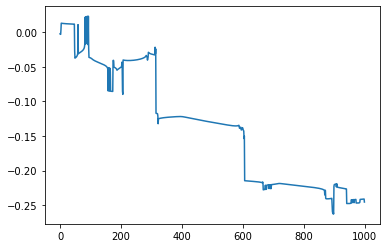

In [148]:
class AttentionHead():
    """Scaled dot product attention head. """
    def __init__(self, embed_dim, n_heads):
        self.embed_dim = embed_dim
        self.output_dim = embed_dim // n_heads
        #self.dim_k = math.sqrt(self.embed_dim // self.output_dim)
        self.dim_k = math.sqrt(self.output_dim)
        
        self.layers = [np.random.randn(self.output_dim, embed_dim) * \
                                 np.sqrt(2 / self.embed_dim) for _ in range(3)]
        
        #TODO find clean alternative
        self.V, self.K, self.Q = self.layers[0], self.layers[1], self.layers[2]
        
        # Useful for calculating gradient
        self.ones = (np.ones((SEQ_LEN, self.output_dim)))
    
    def __call__(self, x, mask=None):
        """Attention forward pass
        Function: softmax(QK^T/sqrt(dim_k) * V)
        """
        # Scaled dot product
        scaled = np.dot(np.dot(self.Q, x.T), np.dot(self.K, x.T).T) / self.dim_k
        
        # Masking (Optional)
        if mask is not None:
            scaled = np.add(mask, scaled)
            
        self.layer_output = np.matmul(nn.softmax(scaled), np.dot(self.V, x.T)).T
        self.layer_output = np.nan_to_num(self.layer_output)
        return(self.layer_output)
    
    def F(self, x):
        """KQ^T/d_k for backprop"""
        return(np.dot(np.dot(self.Q, x.T), np.dot(self.K, x.T).T) / self.dim_k)
    
    def step(self, x, t, alpha=0.0001, eps=1e-9):
        """Step along gradients to update K, Q, V weights."""
        # Softmax derivative
        dS = np.matmul(nn.softmax(self.F(x)), 
                       (np.identity(self.output_dim) - nn.softmax(self.F(x))))
        
        # Cross entropy derivative
        dL = np.divide(-t, self.layer_output)
        dL = dL + ((self.ones - t) / (self.ones - self.layer_output))
        dL[np.isnan(dL)] = 0
        
        # Calculate loss w.r.t weight gradients
        # dL/dK
        dK = np.matmul(self.Q, x.T)
        dK = np.matmul(dK, x).T
        dK = np.diag(1 / self.dim_k * np.kron(dK, np.identity(self.output_dim)))
        
        # dL/dQ
        dQ = np.matmul(self.K, np.matmul(x.T, x))
        dQ = np.kron(np.identity(self.output_dim), self.K)
        dQ = np.diag(1 / self.dim_k * dQ)
        
        # dL/dV
        # TODO
        
        # Calc deltas and update weights
        del_K = np.nan_to_num(np.matmul(dL, np.nan_to_num(dS)))
        self.K -= np.einsum("ki,j->ij", del_K, dK) * alpha
        
        del_Q = np.nan_to_num(np.matmul(dL, dS))
        self.Q -= np.einsum("ki,j->ij", del_Q, dQ) * alpha

        
x = dataset[2]["input_embedding"]
t = dataset[2]["input_embedding"]

head = AttentionHead(MODEL_DIM, NUM_HEADS)

t = t[:,0:8]

output = head(x)
print(nn.cross_entropy(output, t))

outputs = []
for _ in range(1000):
    head.step(x, t[:,0:8])
    output = head(x)
    outputs.append(nn.cross_entropy(output, t))
    
plt.plot(outputs)


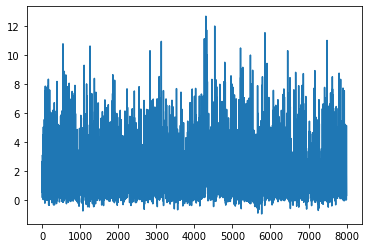

In [152]:
class MultiheadAttention():
    """Multiheaded attention transformer block"""
    def __init__(self, embed_dim=MODEL_DIM, n_heads=NUM_HEADS, 
                 seq_len=SEQ_LEN, masked=False):
        # Class vars
        self.embed_dim = embed_dim
        self.attn_dim = embed_dim // n_heads
        
        # Create all heads and weights for multiheaded attention
        self.heads = [AttentionHead(embed_dim, n_heads) for _ in range(n_heads)]
        self.O = np.random.randn(embed_dim, embed_dim) * math.sqrt(2 / (embed_dim * seq_len))
        
        # If the attention block is masked
        self.mask = None
        if masked:
            self.mask = np.ones((self.attn_dim, self.attn_dim)) * -np.inf
            self.mask = np.triu(self.mask, k=1)
    
    def __call__(self, x):
        """Forward passes through concatenated heads and matmuls by weights"""
        h_cat = np.concatenate([h(x, self.mask) for h in self.heads], axis=1)
        self.layer_output = np.nan_to_num(np.matmul(h_cat, self.O))
        return(self.layer_output)
        
    def backprop(self, x, target, alpha=0.00001):
        """Makes one step along each gradient of each attention head"""
        # TODO Fix this
        for i, h in enumerate(self.heads):
            t = target[:,0 + i * self.attn_dim:(1 + i) * self.attn_dim] #0-32, 33-64, etc.
            h.step(x, t, alpha)
        
        # Derivative of layer given output from multihead attention
        pred = self.layer_output
        delta = -(target / pred)
        delta[np.isnan(delta)] = 0
        delta = (np.ones(target.shape) - target) / (np.ones(pred.shape) - pred)
        delta[np.isnan(delta)] = 0
        self.O -= np.matmul(delta.T, pred).T * alpha
        
        
x = dataset[0]["input_embedding"]
t = dataset[0]["input_embedding"]

attn = MultiheadAttention(MODEL_DIM, NUM_HEADS)

output = attn(x)
#print(output.shape)
#print(nn.cross_entropy(output, t))

outputs = []
for i in range(8000):
    x = dataset[i]["input_embedding"]
    t = dataset[i]["target_embedding"]
    attn.backprop(x, t)
    output = attn(x)
    loss = nn.cross_entropy(output, t)
    outputs.append(loss)
    
plt.plot(outputs)


In [114]:
class FFN(nn.Net):
    """Position-wise feed forward nueral network"""
    def __init__(self, embed_dim=MODEL_DIM, inner_dim=INNER_DIM, sequence_max=SEQUENCE_MAX):
        super(FFN, self).__init__()
        self.L1 = nn.LinearLayer(embed_dim, inner_dim, sequence_max)
        self.L2 = nn.LinearLayer(inner_dim, embed_dim, sequence_max)
        
        self.layers = [
            self.L1,
            self.L2,
        ]
    
    def __call__(self, x):
        """ReLU(xW1 + b1)W2 + b2"""
        x = self.L2(np.maximum(self.L1(x), 0))
        
        return x

In [115]:
#TODO implement layer norm
def layer_norm(layer):
    std = np.std(layer)
    mean = np.mean(layer)
    print(std, mean)
    print(layer)


In [116]:
class EncoderBlock():
    
    """Encoder block for the transformer.
    Args:
            embed_dim (string): Directory with all the images.
            n_heads (string): Path to the csv file with annotations.
            sequence_max (int):
            inner_dim (int):
    """
    def __init__(self, embed_dim=MODEL_DIM, n_heads=NUM_HEADS, 
                 inner_dim=INNER_DIM, sequence_max=SEQ_LEN):
        self.embed_dim = embed_dim
        self.n_heads = n_heads 
        self.seq_len = seq_len 
        
        self.multihead_attn = MultiheadAttention(embed_dim, n_heads)
        self.feedforward = FFN(embed_dim, inner_dim, seq_len)
    
    def temp_add_norm(self, x, y):
        # TODO replace with layer norm function
        x = np.add(x, y) 
        return (x / np.sqrt(np.sum(x**2))).T
        
    def __call__(self, x):
        y = self.multihead_attn(x)
        x = self.temp_add_norm(x, y.T)
        
        y = self.feedforward(x)
        x = self.temp_add_norm(x, y)
        
        return x

#multihead_attn = MultiheadAttention()
#ffn = FFN()
#
#x = dataset[0]["input_embedding"]
#t = dataset[0]["input_embedding"]
#
#x = multihead_attn(x)
#
##multihead_attn.backprop(x, t)
#
#x = multihead_attn(x)


#x = ffn(t.T)
#
#
#ffn.backprop(x, t)
#print(nn.loss(x, t))

#for i in range(x.shape[1]):
#    print(x[:,i].shape, t.T[:,i].shape)
#    ffn.backprop(x[:,i], t.T[:,i])
#    print(nn.loss(x, t.T))
    

#layer_norm(x)
#enc_block = EncoderBlock()